# Model Evaluation and Refinement

## Setup

### Importing Required Libraries

In [1]:
# %pip install tqdm

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import os

%matplotlib inline

### Importing the dataset

In [3]:
dir_path = os.path.join(".", "data")
os.makedirs(dir_path, exist_ok=True)

def download_file(url: str) -> str:
    with requests.get(url=url, stream=True) as response:
        response.raise_for_status()

        filepath = os.path.join(dir_path, url.rsplit("/", 1)[-1])
        total_size = int(response.headers.get("Content-Length", 0))
        chunk_size = 1024 ** 2
        download_size = 0

        with open(filepath, "wb") as file:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue

                file.write(chunk)
                download_size += len(chunk)

                if total_size > 0:
                    progress = (download_size / total_size) * 100
                    print(f"Downloading: {progress:.2f}% ({download_size} / {total_size} bytes)")

    print("Download Complete.")
    return filepath

In [4]:
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv"
filename = download_file(data_url)

Downloading: 100.00% (37048 / 37048 bytes)
Download Complete.


In [5]:
df = pd.read_csv(filename)
df.head()

,Unnamed: 0.1,Unnamed: 0,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,0,0,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,1,1,3,122,alfa-romero,std,two,convertible,rwd,front,...,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,2,2,1,122,alfa-romero,std,two,hatchback,rwd,front,...,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,3,3,2,164,audi,std,four,sedan,fwd,front,...,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,4,4,2,164,audi,std,four,sedan,4wd,front,...,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


## Functions for Plotting

<p>We define the functions that will be used in the lab for making plots at different stages.</p>

In [6]:
def distribution_plot(red_function: pd.Series, blue_function: np.ndarray, red_name: str, blue_name: str, title: str) -> None:
    _wid = 12
    _hei = 10
    plt.figure(figsize=(_wid, _hei))

    ax1 = sns.kdeplot(red_function, color="r", label=red_name)
    sns.kdeplot(blue_function, color="b", label=blue_name, ax=ax1)

    plt.title(title)
    plt.xlabel("Price (in dollars)")
    plt.ylabel("Proportion of Cars")
    plt.legend()

In [7]:
def polly_plot(x_tr: pd.Series, x_te: pd.Series, y_tr: pd.Series, y_te: pd.Series, lr: LinearRegression, pf: PolynomialFeatures) -> None:
    _wid = 12
    _hei = 10
    plt.figure(figsize=(_wid, _hei))

    x_max = max([x_tr.values.max(), x_te.values.max()])
    x_min = min([x_tr.values.min(), x_te.values.min()])
    x = np.arange(x_min, x_max, 0.1)

    plt.plot(x_tr, y_tr, "ro", label="Training Data")
    plt.plot(x_te, y_te, "go", label="Test Data")
    plt.plot(x, lr.predict(pf.fit_transform(x.reshape(-1, 1))), label="Predicted Function")
    plt.ylim([-10000, 60000])
    plt.ylabel("Price")
    plt.legend()

## Part 1 - Training and Testing

<p>An important step in testing your model is to split your data into training and testing data. We will place the target data <code>price</code> in a separate dataframe <code>y_data</code>.</p>

In [8]:
y_data = df["price"]

<p>Drop price data in dataframe <code>x_data</code>.</p>

In [9]:
x_data = df.drop("price", axis=1)

<p>Now, we randomly split our data into training and testing data using the function <code>train_test_split()</code>.</p>

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)

print(f"number of test samples: {x_test.shape[0]}")
print(f"number of training samples: {x_train.shape[0]}")

number of test samples: 21
number of training samples: 180


<p>The <code>test_size</code> parameter sets the proportion of data that is split into the testing set. In the above, the testing set is 10% of the total dataset.</p>

### Question 1

<p><b>Question 1.1</b> Use the function <code>train_test_split()</code> to split up the dataset such that 40% of the data samples will be utilized for testing. Set the parameter <code>random_state</code> equal to zero. The output of the function should be the following: <code>x_train1</code>, <code>x_test1</code>, <code>y_train1</code> and <code>y_test1</code>.</p>

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.40, random_state=0)

print(f"number of test samples: {x_test1.shape[0]}")
print(f"number of training samples: {x_train1.shape[0]}")

number of test samples: 81
number of training samples: 120


<p>We create a Linear Regression object:</p>

In [12]:
lm = LinearRegression()

<p>We fit the model using the feature <code>horsepower</code>.</p>

In [13]:
lm.fit(x_train[["horsepower"]], y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<p>Let's calculate the $R^2$ on the test data.</p>

In [14]:
lm.score(x_test[["horsepower"]], y_test)

0.36358755750788263

<p>We can see the $R^2$ is much smaller using the test data compared to the training data.</p>

In [15]:
lm.score(x_train[["horsepower"]], y_train)

0.6619724197515104

<p><b>Question 1.2</b> Find the $R^2$ on the test data using 40% of the dataset for testing.</p>

In [16]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.40, random_state=0)
lm.fit(x_train1[["horsepower"]], y_train1)
lm.score(x_test1[["horsepower"]], y_test1)

0.7139364665406973

<p>Sometimes you do not have sufficient testing data. As a result, you may want to perform cross-validation. Let's go over several methods that you can use for cross-validation.</p>

## Cross-Validation Score

<p>We input the object, the feature <code>horsepower</code>, and the target data <code>y_data</code>. The parameter <code>cv</code> determines the number of folds. In this case, it's 4.</p>

In [17]:
r_cross = cross_val_score(lm, x_data[["horsepower"]], y_data, cv=4)

<p>The default scoring is $R^2$. Each element in the array has the average $R^2$ value for the fold.</p>

In [18]:
r_cross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

<p>We can calculate the average and standard deviation of our estimate:</p>

In [19]:
print(f"The mean of the folds are {r_cross.mean()} and the standard deviation is {r_cross.std()}.")

The mean of the folds are 0.522009915042119 and the standard deviation is 0.2911839444756029.


<p>We can use negative squared error as a score by setting the parameter <code>scoring</code> metric to <code>neg_mean_squared_error</code>.</p>

In [20]:
-1 * cross_val_score(lm, x_data[["horsepower"]], y_data, cv=4, scoring="neg_mean_squared_error")

array([20254142.84026702, 43745493.2650517 , 12539630.34014931,
       17561927.7224759 ])

### Question 2

<p>Calculate the average $R^2$ using two folds, then find the average $R^2$ for the second fold utilizing the <code>horsepower</code> feature.</p>

In [21]:
rc = cross_val_score(lm, x_data[["horsepower"]], y_data, cv=2)
rc.mean()

np.float64(0.5166761697127429)

<p>You can also use the function <code>cross_val_predict</code> to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training.</p>
<p>Now, we input the object, the feature <code>horsepower</code>, and the target data <code>y_data</code>. The parameter <code>cv</code> determines the number of folds. In this case, it's 4. We can produce an output:</p>

In [22]:
y_hat = cross_val_predict(lm, x_data[["horsepower"]], y_data, cv=4)
y_hat[0: 5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

## Part 2 - Overfitting, Underfitting and Model Selection

<p>It turns out that the test data, sometimes referred to as the "out of sample", is a much better measure of how well you model performs in the real world. One reason for this is overfitting.</p>
<p>Let's go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.</p>

<p>Let's create Multiple Linear Regression objects and train the model using <code>horsepower</code>, <code>curb-weight</code>, <code>engine-size</code> and <code>highway-mpg</code> as features.</p>

In [23]:
lm1 = LinearRegression()
training_data = x_train[["horsepower", "curb-weight", "engine-size", "highway-mpg"]]
lm1.fit(training_data, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<p>Prediction using training data.</p>

In [24]:
y_hat_train = lm1.predict(training_data)
y_hat_train[0: 5]

array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
       34500.19124244])

<p>Prediction using test data.</p>

In [25]:
y_hat_test = lm1.predict(x_test[["horsepower", "curb-weight", "engine-size", "highway-mpg"]])
y_hat_test[0: 5]

array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
       15565.79920282])

<p>Let's examine the distribution of the predicted values of the training data.</p>

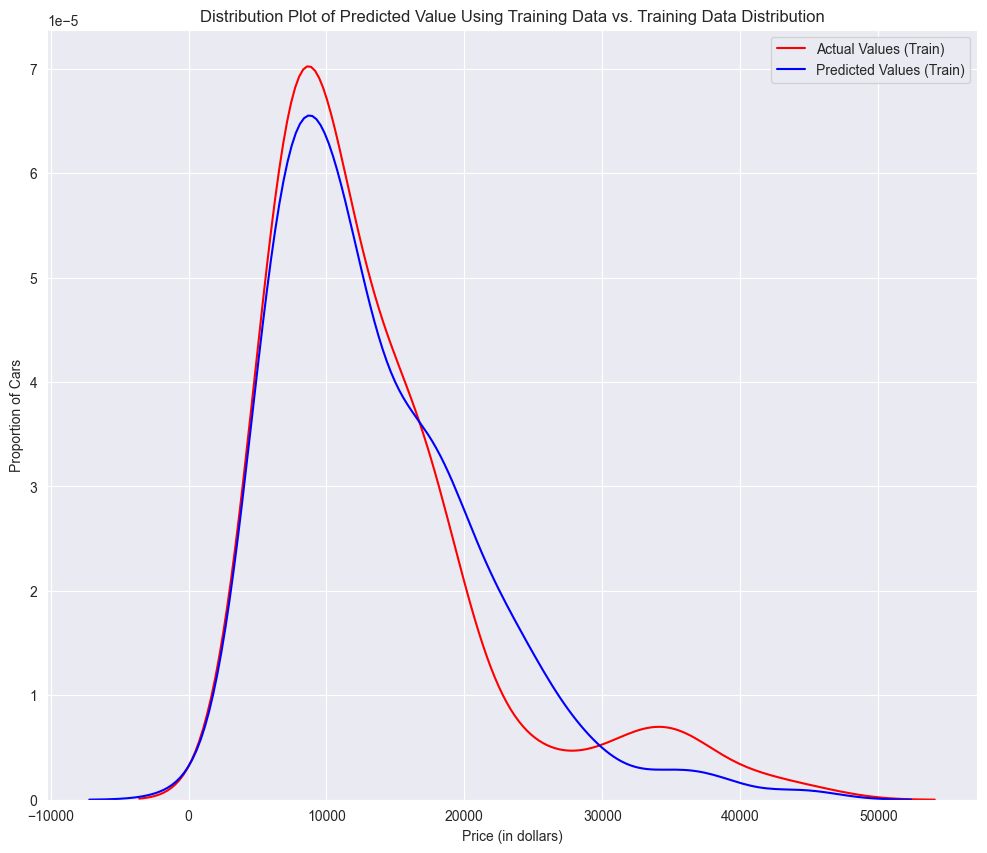

In [26]:
distribution_plot(y_train, y_hat_train, "Actual Values (Train)", "Predicted Values (Train)", "Distribution Plot of Predicted Value Using Training Data vs. Training Data Distribution")

<p>Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.</p>

<p>So far, the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.</p>

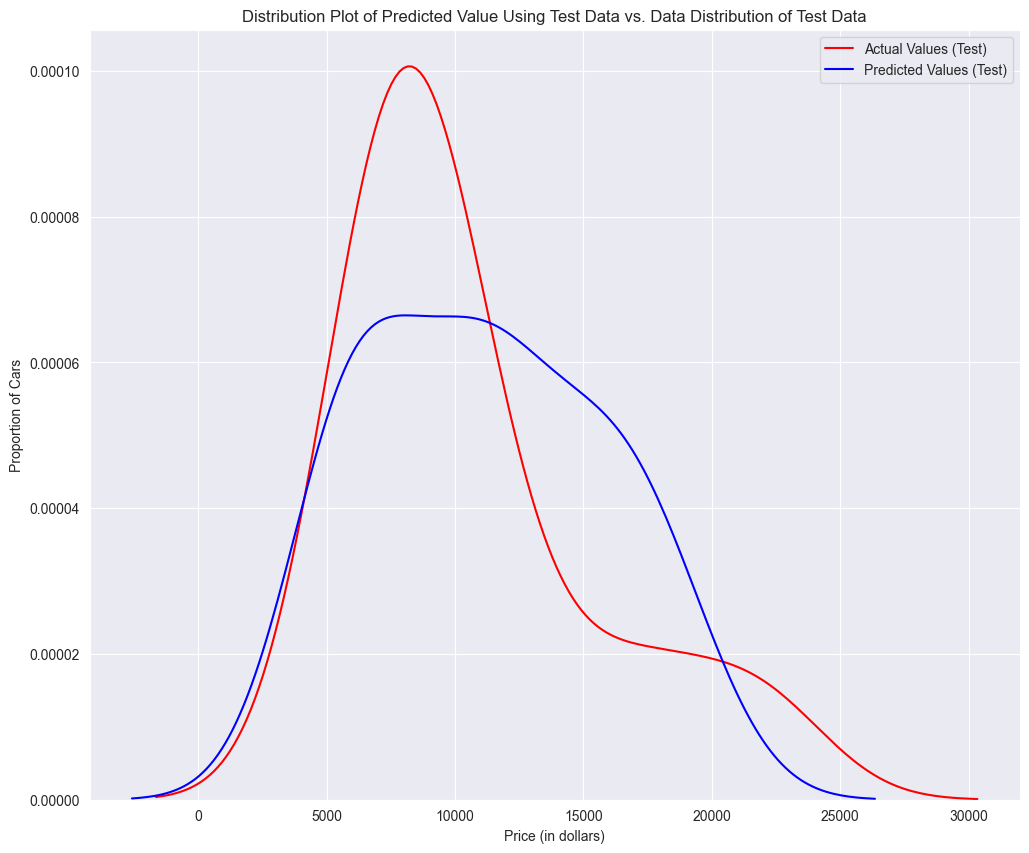

In [27]:
distribution_plot(y_test, y_hat_test, "Actual Values (Test)", "Predicted Values (Test)", "Distribution Plot of Predicted Value Using Test Data vs. Data Distribution of Test Data")

<p>Figure 2: Plot of predicted value using the test data compared to the actual values of the test data.</p>

<p>Comparing Figure 1 and Figure 2, it is evident that the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent in the range of 5000 to 15,000. This is where the shape of the distribution is extremely different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.</p>

### Overfitting

<p>Overfitting occurs when the model fits the noise, but not the underlying process. Therefore, when testing your model using the test set, your model does not perform as well since it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.</p>

<p>Let's use 45% of the data for training and the rest for testing.</p>

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

<p>We will perform a degree 5 polynomial transformation on the feature <code>horsepower</code>.</p>

In [29]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[["horsepower"]])
x_test_pr = pr.fit_transform(x_test[["horsepower"]])
pr

,degree,5
,interaction_only,False
,include_bias,True
,order,'C'


<p>Now, let's create a Linear Regression model <code>poly</code> and train it.</p>

In [30]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<p>We can see the output of our model using the method <code>predict()</code>. We assign the values to <code>y_hat</code>.</p>

In [31]:
y_hat = poly.predict(x_test_pr)
y_hat[0: 5]

array([ 6728.65566037,  7307.9878638 , 12213.7877412 , 18893.24796457,
       19995.95185894])

<p>Let's take the first five predicted values and compare it to the actual targets.</p>

In [32]:
print(f"Predicted Values: {y_hat[0: 4]}")
print(f"True Values: {y_test[0: 4].values}")

Predicted Values: [ 6728.65566037  7307.9878638  12213.7877412  18893.24796457]
True Values: [ 6295. 10698. 13860. 13499.]


<p>We will use the function <code>polly_plot()</code> that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.</p>

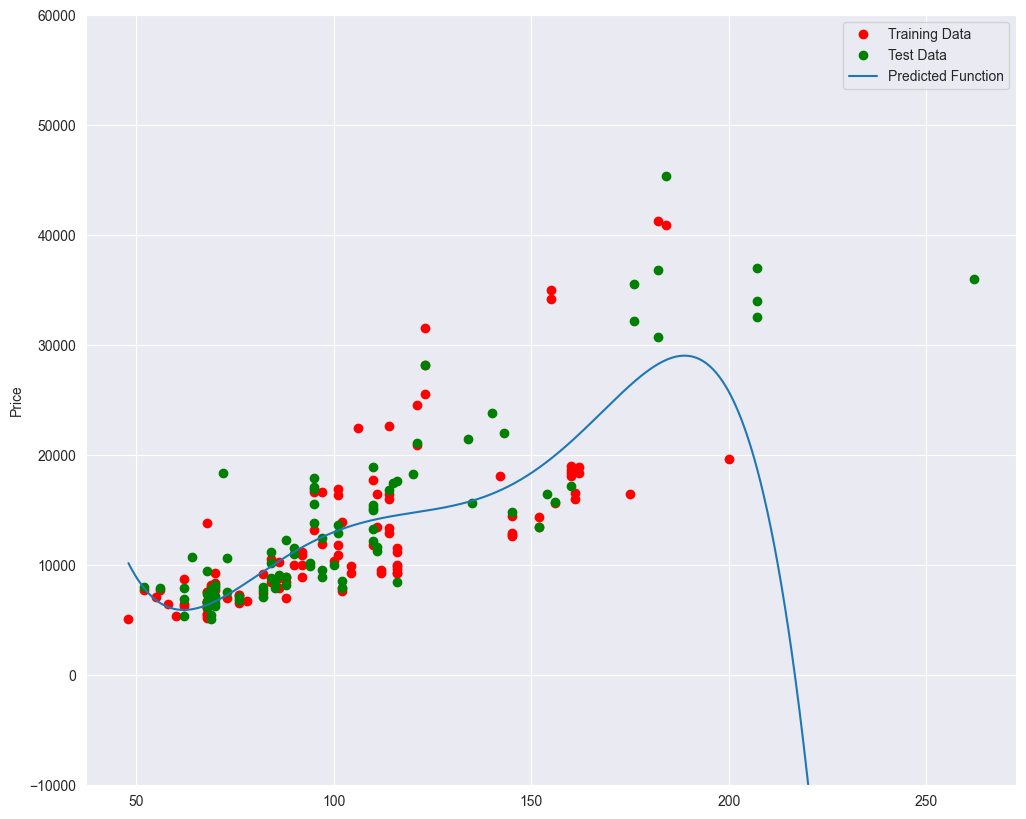

In [33]:
polly_plot(x_train["horsepower"], x_test["horsepower"], y_train, y_test, poly, pr)

<p>Figure 3: A polynomial regression model where red dots represent training data, green dots represent test data, and the blue line represents the model prediction.</p>

<p>We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.</p>

<p>$R^2$ of the training data:</p>

In [34]:
poly.score(x_train_pr, y_train)

0.5567716902121724

<p>$R^2$ of the test data:</p>

In [35]:
poly.score(x_test_pr, y_test)

-29.87134054062532

<p>We see the $R^2$ for the training data is 0.5567 while the $R^2$ on the test data was -29.87.  The lower the $R^2$, the worse the model. A negative $R^2$ is a sign of overfitting.</p>

<p>Let's see how the $R^2$ changes on the test data for different order polynomials and then plot the results:</p>

Text(3, 0.75, 'Maximum R-square')

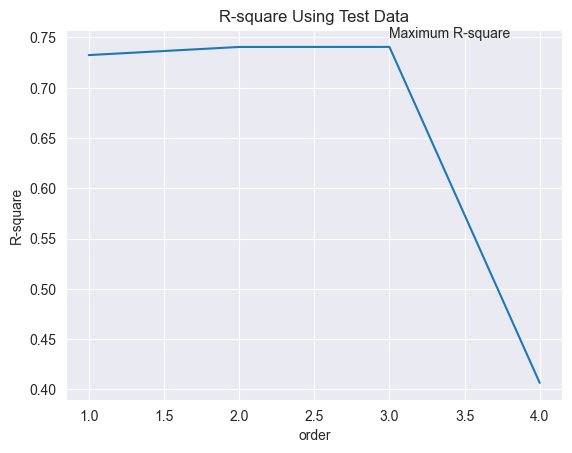

In [36]:
r_square_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[["horsepower"]])
    x_test_pr = pr.fit_transform(x_test[["horsepower"]])
    lm1.fit(x_train_pr, y_train)
    r_square_test.append(lm1.score(x_test_pr, y_test))

plt.plot(order, r_square_test)
plt.xlabel("order")
plt.ylabel("R-square")
plt.title("R-square Using Test Data")
plt.text(3, 0.75, "Maximum R-square")

<p>We see the $R^2$ gradually increases until an order three polynomial is used. Then, the $R^2$ dramatically decreases at an order four polynomial.</p>

### Question 3

<p><b>Question 3.1</b> We can perform polynomial transformations with more than one feature. Create a <code>PolynomialFeatures</code> object <code>pr1</code> of degree two.</p>

In [37]:
pr1 = PolynomialFeatures(degree=2)

<p><b>Question 3.2</b> Transform the training and testing samples for the features <code>horsepower</code>, <code>curb-weight</code>, <code>engine-size</code> and <code>highway-mpg</code>.</p>
<p>Hint: Use the method <code>fit_transform</code>.</p>

In [38]:
x_train_pr1 = pr1.fit_transform(x_train[["horsepower", "curb-weight", "engine-size", "highway-mpg"]])
x_test_pr1 = pr1.fit_transform(x_test[["horsepower", "curb-weight", "engine-size", "highway-mpg"]])

<p><b>Question 3.3</b> How many dimensions does the new feature have?</p>
<p>Hint: use the attribute <code>shape</code>.</p>

In [39]:
x_train_pr1.shape

(110, 15)

<p><b>Question 3.4</b> Create a linear regression model <code>poly1</code>. Train the object using the method <code>fit</code> using the polynomial features.</p>

In [40]:
poly1 = LinearRegression()
poly1.fit(x_train_pr1, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<p><b>Question 3.5</b> Use the method <code>predict()</code> to predict an output on the polynomial features, then use the function <code>distribution_plot()</code> to display the distribution of the predicted test output vs. the actual test data.</p>

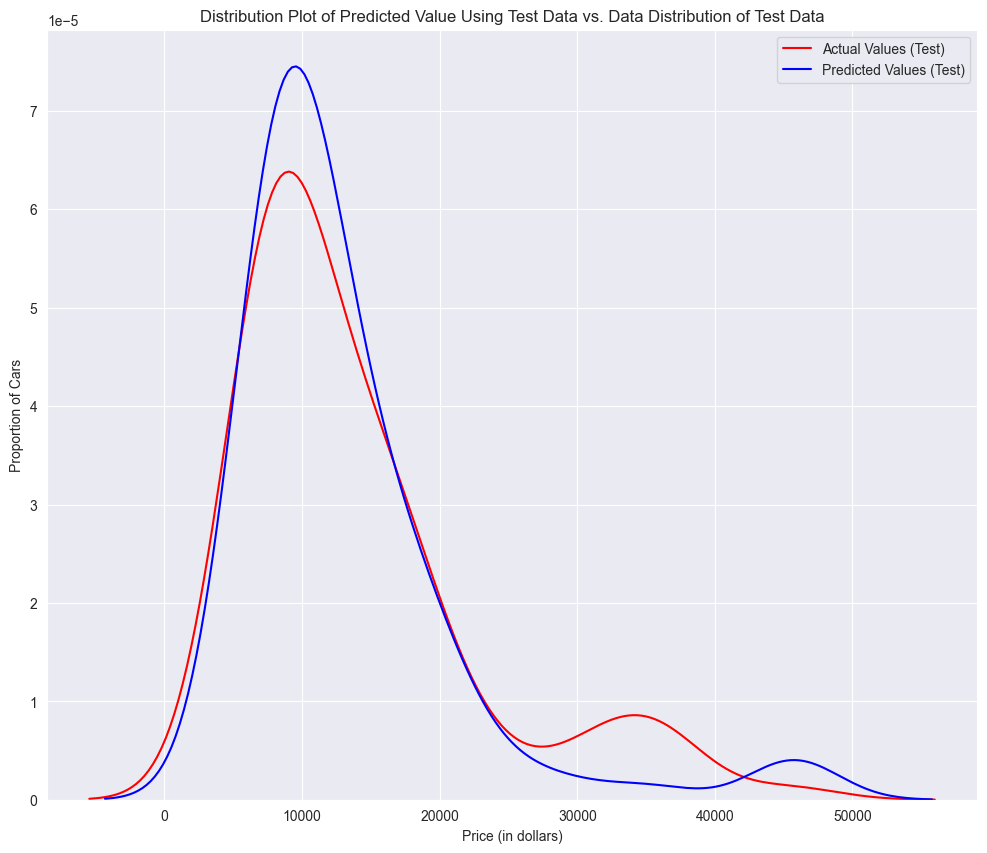

In [41]:
y_hat_test1 = poly1.predict(x_test_pr1)

distribution_plot(y_test, y_hat_test1, "Actual Values (Test)", "Predicted Values (Test)", "Distribution Plot of Predicted Value Using Test Data vs. Data Distribution of Test Data")

## Part 3 - Ridge Regression

<p>In this section, we will review Ridge Regression and see how the parameter alpha changes the model. Just a note, here our test data will be used as validation data.</p>
<p>Let's perform a degree two polynomial transformation on our data.</p>

In [42]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[["horsepower", "curb-weight", "engine-size", "highway-mpg", "normalized-losses", "symboling"]])
x_test_pr = pr.fit_transform(x_test[["horsepower", "curb-weight", "engine-size", "highway-mpg", "normalized-losses", "symboling"]])

<p>Let's create a Ridge Regression object, setting the regularization parameter (alpha) to 1.</p>

In [43]:
ridge_model = Ridge(alpha=1)

<p>Like regular regression, you can fit the model using the method <code>fit()</code>.</p>

In [44]:
ridge_model.fit(x_train_pr, y_train)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


<p>Similarly, you can obtain a prediction.</p>

In [45]:
y_hat = ridge_model.predict(x_test_pr)

<p>Let's compare the first four predicted samples to our test set.</p>

In [46]:
print(f"Predicted: {y_hat[0: 4]}")
print(f"Test Set: {y_test[0: 4].values}")

Predicted: [ 6570.82441941  9636.24891471 20949.92322737 19403.60313256]
Test Set: [ 6295. 10698. 13860. 13499.]


<p>We select the value of alpha that minimizes the test error. To do so, we can use a for loop. We have also created a progress bar to see how many iterations we have completed so far.</p>

In [47]:
r_square_test = []
r_square_train = []

alpha = 10 * np.array(range(0, 1000))
pbar = tqdm(alpha)

for a in pbar:
    ridge_model = Ridge(alpha=a)
    ridge_model.fit(x_train_pr, y_train)

    test_score = ridge_model.score(x_test_pr, y_test)
    train_score = ridge_model.score(x_train_pr, y_train)

    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    r_square_test.append(test_score)
    r_square_train.append(train_score)

100%|██████████| 1000/1000 [00:02<00:00, 419.62it/s, Test Score=0.564, Train Score=0.859]


<p>We can plot out the value of $R^2$ for different alphas.</p>

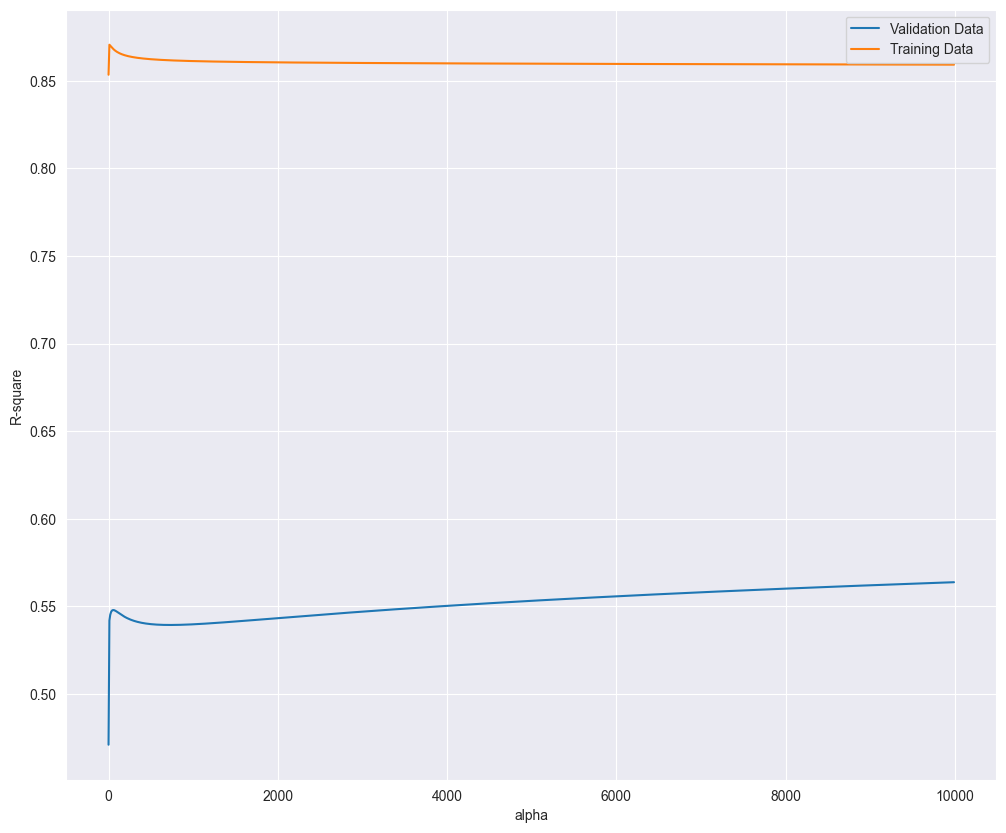

In [48]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(alpha, r_square_test, label="Validation Data")
plt.plot(alpha, r_square_train, label="Training Data")
plt.xlabel("alpha")
plt.ylabel("R-square")
plt.legend()

<p>Figure 4: The bule line represents the $R^2$ of the validation data, and the red line represents the $R^2$ of the training data. The x-axis represents the different values of alpha.</p>

<p>Here the model is built and tested on the same data, so the training and test data are the same.</p>
<p>The red line in Figure 4 represents the $R^2$ of the training data. As alpha increases the $R^2$ decreases. Therefore, as alpha increases, the model performs worse on the training data.</p>
<p>The blue line represents the $R^2$ on the validation data. As the value for alpha increases, the $R^2$ increases and converges at a point.</p>

### Question 4

<p>Perform Ridge regression. Calculate the $R^2$ using the polynomial features, use the training data to train the model and use the test data to test the model. The parameter alpha should be set to 10.</p>

In [49]:
ridge_model = Ridge(alpha=10)
ridge_model.fit(x_train_pr, y_train)
ridge_model.score(x_test_pr, y_test)

0.5418576440206506

## Part 4 - Grid Search

<p>The term alpha is a hyperparameter. <code>Scikit-learn</code> has the class <code>GridSearchCV</code> to make the process of finding the best hyperparameter simpler.</p>

<p>We create a dictionary of parameter values.</p>

In [50]:
para1 = [{"alpha": [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

<p>Create a Ridge Regression object.</p>

In [51]:
ridge = Ridge()

<p>Create a Ridge Grid Search object.</p>

In [52]:
grid1 = GridSearchCV(ridge, para1, cv=4)

<p>Fit the model.</p>

In [53]:
grid1.fit(x_data[["horsepower", "curb-weight", "engine-size", "highway-mpg"]], y_data)

,estimator,Ridge()
,param_grid,"[{'alpha': [0.001, 0.1, ...]}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10000


<p>The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable <code>best_est</code> as follows:</p>

In [54]:
best_est = grid1.best_estimator_
best_est

,alpha,10000
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


<p>We now test our model on the test data.</p>

In [55]:
best_est.score(x_test[["horsepower", "curb-weight", "engine-size", "highway-mpg"]], y_test)

0.8411649831036152

### Question 5

<p>Perform a grid search for the alpha parameter and the normalization parameter, then find the best values of the parameters.</p>

In [56]:
para2 = [{"alpha": [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

grid2 = GridSearchCV(Ridge(), para2, cv=4)
grid2.fit(x_data[["horsepower", "curb-weight", "engine-size", "highway-mpg"]], y_data)
best_alpha = grid2.best_params_["alpha"]
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(x_data[["horsepower", "curb-weight", "engine-size", "highway-mpg"]], y_data)

,alpha,10000
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


****
This is the end of the file.
****